In [1]:
%pylab inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from PIL import Image
import argparse
import numpy as np
import os
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 定义VGG模型，前向时抽取0,5,10,19,28层卷积特征
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract 5 conv activation maps from an input image.
        
        Args:
            x: 4D tensor of shape (1, 3, height, width).
        
        Returns:
            features: a list containing 5 conv activation maps.
        """
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)  # 依次输出并且截取
            if name in self.select:
                features.append(x)
        return features

In [3]:
#定义加载图像函数，并将PIL image转化为Tensor
use_gpu = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_gpu else torch.FloatTensor
if dtype == torch.cuda.FloatTensor:
    device = 0
else:
    device = -1

def load_image(image_path, transforms=None, max_size=None, shape=None):
    image = Image.open(image_path)
    image_size = image.size

    if max_size is not None:
        #获取图像size，为sequence
        image_size = image.size
        #转化为float的array
        size = np.array(image_size).astype(float)
        size = max_size / size * size;
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape is not None:
        image = image.resize(shape, Image.LANCZOS)

    #必须提供transform.ToTensor，转化为4D Tensor
    if transforms is not None:
        image = transforms(image).unsqueeze(0)

    #是否拷贝到GPU
    return image.to(device)

In [4]:
def main(config):
    #定义图像变换操作，必须定义.ToTensor()。（可做）
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
        ])

    #content和style图像，style图像resize成同样大小
    content = load_image(config["content"], transform, max_size = config["max_size"])
    style = load_image(config["style"], transform, shape = [content.size(2), content.size(3)])

    #将concent复制一份作为target，并需要计算梯度，作为最终的输出
    target = Variable(content.clone(), requires_grad = True)
    optimizer = torch.optim.Adam([target], lr = config["lr"], betas=[0.5, 0.999])

    vgg = VGGNet()
    if use_gpu:
        vgg = vgg.cuda()

    for step in range(config["total_step"]):
        #分别计算target、content、style的特征图
        target_features = vgg(target)
        content_features = vgg(Variable(content))
        style_features = vgg(Variable(style))

        content_loss = 0.0
        style_loss = 0.0

        for f1, f2, f3 in zip(target_features, content_features, style_features):
            #计算content_loss
            ######################################
            content_loss += torch.mean((f1 - f2)**2)
            ######################################

            #将特征reshape成二维矩阵相乘，求gram矩阵
            ######################################
            _, featrue_channel, feature_height, feature_width = f1.size()  # channel height width
            f1 = f1.view(featrue_channel, feature_height * feature_width) 
            f3 = f3.view(featrue_channel, feature_height * feature_width)  # reshape 成如此格式

            # gram matrix  这是一种全局特征上的自相关？
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())
            ######################################

            #计算style_loss
            ######################################
            style_loss += torch.mean((f1 - f3)**2) / (featrue_channel*feature_height * feature_width)
            # 两个 gram 矩阵之间的距离为loss 值
            ######################################

        #计算总的loss
        ######################################
        loss = content_loss + config["style_weight"] * style_loss 
        ######################################
        
        #反向求导与优化
        ######################################
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ######################################

        if (step+1) % config["log_step"] == 0:
            print ('Step [%d/%d], Content Loss: %.4f, Style Loss: %.4f'
                   %(step+1, config["total_step"], content_loss.data, style_loss.data))

        if (step+1) % config["sample_step"] == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().cpu().squeeze()
            img = denorm(img.data).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-%d.png' %(step+1))

In [6]:
if __name__ == "__main__":
    begin_time = time.time()
    
    config = {}
    content = './content.jpg'
    style = './style.jpg'
    max_size = 400
    total_step = 5000
    log_step = 10
    sample_step = 1000
    style_weight = 100 
    lr = 0.003
    
    config["content"] = content
    config["style"] = style
    config["max_size"] = max_size
    config["total_step"] = total_step
    config["sample_step"] = sample_step
    config["style_weight"] = style_weight
    config["log_step"] = style_weight
    config["lr"] = lr

    print(config)
    main(config)
    final_time = time.time()
    print(begin_time - final_time)

{'content': './content.jpg', 'style': './style.jpg', 'max_size': 400, 'total_step': 5000, 'sample_step': 1000, 'style_weight': 100, 'log_step': 100, 'lr': 0.003}
Step [100/5000], Content Loss: 25.9175, Style Loss: 502.1901
Step [200/5000], Content Loss: 31.3365, Style Loss: 344.0558
Step [300/5000], Content Loss: 34.2266, Style Loss: 252.9169
Step [400/5000], Content Loss: 36.1193, Style Loss: 195.4292
Step [500/5000], Content Loss: 37.4797, Style Loss: 158.4610
Step [600/5000], Content Loss: 38.4768, Style Loss: 133.8161
Step [700/5000], Content Loss: 39.2523, Style Loss: 116.3001
Step [800/5000], Content Loss: 39.8965, Style Loss: 103.0872
Step [900/5000], Content Loss: 40.4486, Style Loss: 92.6772
Step [1000/5000], Content Loss: 40.9347, Style Loss: 84.1795
Step [1100/5000], Content Loss: 41.3660, Style Loss: 77.0335
Step [1200/5000], Content Loss: 41.7722, Style Loss: 70.8920
Step [1300/5000], Content Loss: 42.1387, Style Loss: 65.5402
Step [1400/5000], Content Loss: 42.4995, Style

### Anime 生成

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

path_pre = "/home/blueberry/dl/e5/output-"
path_back = ".png"
image = ["1000","2000","3000","4000","5000"]

image = [Image.open(path_pre+i+path_back) for i in image]

In [32]:
Image.open("content.jpg").resize((400,400)).save("result.gif", format = 'GIF' ,save_all=True, append_images=image, duration=1000,loop = 10)


In [11]:
 i_r = Image.open("result.gif")

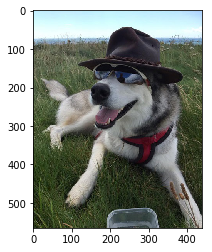

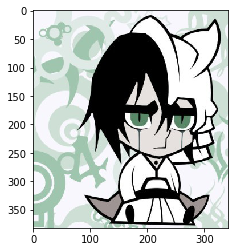

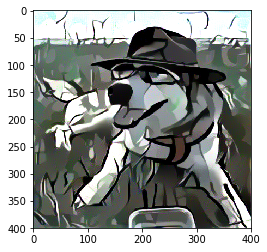

In [22]:
plt.imshow(plt.imread("content.jpg"))
plt.show()
plt.imshow(plt.imread("style.jpg"))
plt.show()
plt.imshow(plt.imread(path_pre+"5000"+path_back))
plt.show()